In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from pathlib import Path

In [2]:
# Images directory

figsdir = Path.cwd() / 'ex2figs'
figsdir.mkdir(parents=True, exist_ok=True);

In [3]:
# Data directory

datadir = Path.cwd() / 'data/ex2'

In [4]:
def plot_data(x, y, labels, axes=None):
    pos = (y == 1).ravel()
    neg = (y == 0).ravel()
    
    if axes == None:
        axes = plt.gca()
    
    axes.plot(x[pos, 0], x[pos, 1], 'k+', x[neg, 0], x[neg, 1], 'yo')
    axes.set_xlabel(labels[0])
    axes.set_ylabel(labels[1])
    axes.legend(loc='upper center', labels=labels[2:], bbox_to_anchor=(0.5,-0.15));

# Logistic regression

In [5]:
data = pd.read_csv(datadir / 'ex2data1.txt', names=['Exam 1 score', 'Exam 2 score', 'Admitted'])

x = np.c_[data['Exam 1 score'], data['Exam 2 score']]
y = np.c_[data['Admitted']]

data.head()

,Exam 1 score,Exam 2 score,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## Data visualization

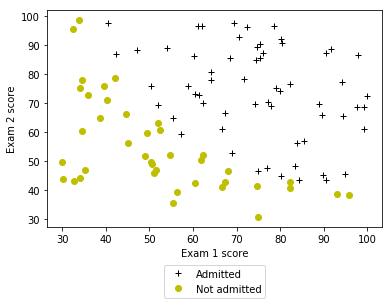

In [6]:
pos = (y == 1).ravel()
neg = (y == 0).ravel()

plot_data(x, y, labels=['Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted'])
plt.savefig(figsdir / 'data_1.png', bbox_inches='tight')

## Cost function and gradient

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
def cost_function(theta, x, y):
    h = sigmoid(x.dot(theta))
    return -np.sum(y.T.dot(np.log(h)) + (1 - y.T).dot(np.log(1 - h))) / len(x)

In [9]:
def gradient(theta, x, y):
    z = x.dot(theta.reshape(-1, 1))
    grad = x.T.dot(sigmoid(z) - y) / len(x)
    return grad.ravel()

In [10]:
x = np.c_[np.ones(data.shape[0]), x]
initial_theta = np.zeros(x.shape[1])

J, grad = cost_function(initial_theta, x, y), gradient(initial_theta, x, y),

print('Cost at initial theta (zeros): {}'.format(J))
print('Gradient at initial theta (zeros):\n {}'.format(grad))

Cost at initial theta (zeros): 0.6931471805599452
Gradient at initial theta (zeros):
 [ -0.1        -12.00921659 -11.26284221]


In [11]:
res = minimize(cost_function, initial_theta, args=(x, y), jac=gradient)
theta = res.x

print('Cost at theta {}: {}'.format(theta, res.fun))

Cost at theta [-25.16133284   0.2062317    0.2014716 ]: 0.20349770158944377


/home/gioggio/anaconda3/envs/mlai/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
def predict(theta, x, threshold=0.5):
    prediction = sigmoid(x.dot(theta.T)) >= threshold
    
    return prediction.astype('int')

In [13]:
# Student with Exam 1 score 45 and Exam 2 score 85
# Predict using the optimized Theta values from above (res.x)

prediction = sigmoid(np.array([1, 45, 85]).dot(theta.T))

print('For a student with scores 45 and 85 we predict a an admission probability of {}'
      .format(prediction))

For a student with scores 45 and 85 we predict a an admission probability of 0.776290724058894


## Decision boundary visualization

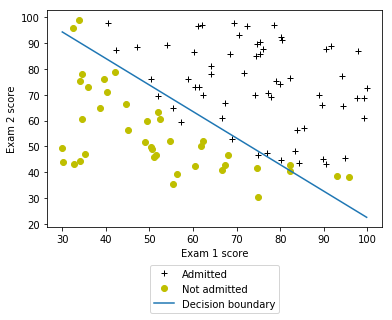

In [14]:
x_plot = np.array((x[:, 1].min(), x[:, 1].max()))
y_plot = -(1/theta[2]) * (theta[0] + theta[1] * x_plot)

plt.plot(x[pos, 1], x[pos, 2], 'k+', x[neg, 1], x[neg, 2], 'yo')
plt.plot(x_plot, y_plot)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(loc='upper center', labels=['Admitted', 'Not admitted', 'Decision boundary'], bbox_to_anchor=(0.5,-0.15));

plt.savefig(figsdir / 'decision_boundary_1.png', bbox_inches='tight')

# Regularized logistic regression

In [15]:
data = pd.read_csv(datadir / 'ex2data2.txt', names=['Microchip Test 1', 'Microchip Test 2', 'Accepted'])

x = np.c_[data['Microchip Test 1'], data['Microchip Test 2']]
y = np.c_[data['Accepted']]

data.head()

,Microchip Test 1,Microchip Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## Data visualization

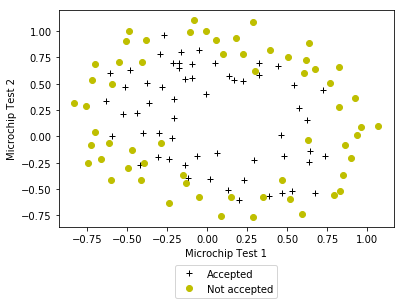

In [16]:
pos = (y == 1).ravel()
neg = (y == 0).ravel()

plot_data(x, y, labels=['Microchip Test 1', 'Microchip Test 2', 'Accepted', 'Not accepted'])
plt.savefig(figsdir / 'data_2.png', bbox_inches='tight')

## Cost function and gradient

In [17]:
def cost_function_reg(theta, x, y, reg=0):
    h = sigmoid(x.dot(theta))
    return -(np.sum(y.T.dot(np.log(h)) + (1 - y.T).dot(np.log(1 - h))) - (reg/2) * np.sum(np.square(theta[1:]))) / len(x)

In [18]:
def gradient_reg(theta, x, y, reg):
    h = sigmoid(x.dot(theta.reshape(-1, 1)))
    grad = np.zeros(theta.shape)
    
    grad[0] = np.sum(x[:, 0].T.dot(h - y)) / len(x)
    grad[1:] = ((x[:, 1:].T.dot(h - y)).ravel() + reg * theta[1:]) / len(x)
    
    return grad

In [19]:
# Create polynomial features up to the sixth grade
poly = PolynomialFeatures(6)
poly_x = poly.fit_transform(x)

In [20]:
initial_theta = np.zeros(poly_x.shape[1])
reg = 1

J = cost_function_reg(initial_theta, poly_x, y, reg)
grad = gradient_reg(initial_theta, poly_x, y, reg)

print('Cost at initial theta (zeros): {}'.format(J))
print('Gradient at initial theta (zeros):\n {}'.format(grad))

Cost at initial theta (zeros): 0.6931471805599453
Gradient at initial theta (zeros):
 [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]


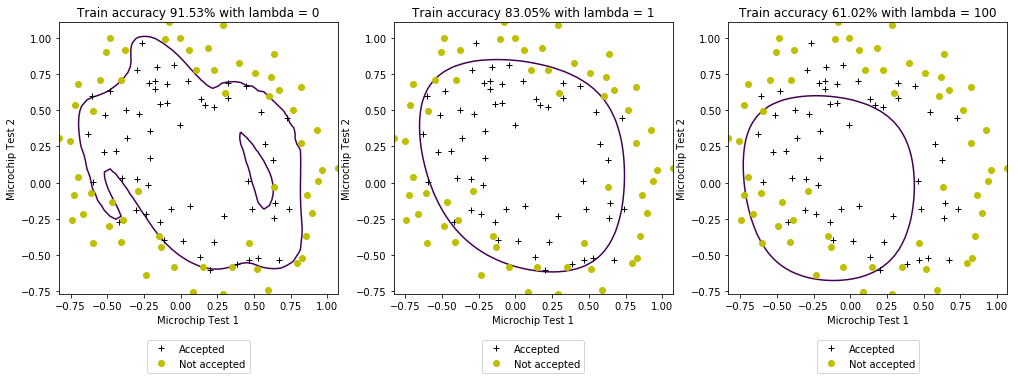

In [21]:
_, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, reg in enumerate([0, 1, 100]):
    res = minimize(cost_function_reg, initial_theta, args=(poly_x, y, reg), jac=gradient_reg)
    
    accuracy = 100 * sum(predict(res.x, poly_x) == y.ravel()) / y.size
    
    plot_data(x, y, ['Microchip Test 1', 'Microchip Test 2', 'Accepted', 'Not accepted'], axes[i])
    
    xx, yy = np.meshgrid(np.linspace(x[:, 0].min(), x[:, 0].max()), np.linspace(x[:, 1].min(), x[:, 1].max()))
    
    feature = np.c_[xx.ravel(), yy.ravel()]
    h = sigmoid(poly.fit_transform(feature).dot(res.x))
    h = h.reshape(xx.shape)
    axes[i].contour(xx, yy, h, [0.5])
    axes[i].set_title('Train accuracy {:.2f}% with lambda = {}'.format(accuracy, reg))
    
plt.savefig(figsdir / 'decision_boundary_regularization.png', bbox_inches='tight')